In [2]:
##############################################网银模型##############################################################################
from scorecard_functions import *
from util import *
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
import gc
import math


import pandas as pd
import re
import time
import datetime
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegressionCV
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
#import requests,urllib,json,datetime,pymysql,uuid
from tqdm import tqdm

 
# from sklearn.model_selection import GridSearchCV
# from sklearn.cross_validation import cross_val_score
from sklearn import preprocessing
from sklearn.linear_model import Lasso,LassoCV   # Lasso回归,LassoCV交叉验证实现alpha的选取，LassoLarsCV基于最小角回归交叉验证实现alpha的选取

In [58]:
'''
一、读入数据
1、如果数据集是整个样本的话，直接运行这一段
'''
mydata=pd.read_csv("F:/onbank_model/myPython/onbank_xzd.csv")##encoding='gbk'  ,自己导出来的数据需要加这个，金莲导出来的不需要
mydata=mydata.drop_duplicates(["consumer_no"])
##目标变量
mydata['target']=mydata['max_overdue_day'].apply(lambda x: 0 if x==0 else 2 if x<7 else 1)
mydata=mydata[mydata['target']!=2]
mydata=mydata.drop(["consumer_no","max_overdue_day","nearest_query_time","farthest_query_time","nearest_pass_time","nearest_unpass_time"],axis=1)
mydata.head()

,query_times,org_count,avg_query_times,nearest_pass_org,nearest_unpass_org,avg_loan_days,avg_loan_success_days,avg_install_days,loan_ratio,loan_success_ratio,...,other_size,frequency_size,calls_percent,linkman_count,phone_long_rate,phone_long_count,phone_short_rate,phone_short_count,zm_score,target
0,2.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0.779,103,1,103,0,0,608,0
1,20.0,11.0,0.0,103.0,103.0,11.0,4.0,1.0,0.64,0.41,...,0,0,0.349,306,1,432,0,0,415,0
3,15.0,12.0,0.0,NaN,230.0,4.0,0.0,0.0,0.75,0.00,...,0,0,0.687,122,1,122,0,0,608,0
4,24.0,14.0,0.0,218.0,368.0,5.0,3.0,0.0,0.71,0.53,...,0,0,0.864,401,1,410,0,0,625,0
5,3.0,3.0,0.0,NaN,251.0,0.0,0.0,0.0,1.00,0.00,...,0,0,0.535,36,1,37,0,0,560,0


In [3]:
'''
2、如果数据集是按照 好、坏样本分别存储的话先跑这一段，然后注释掉
'''
# bad=pd.read_csv("F:/onbank_model/myPython/bad.csv",encoding='gbk')
# good=pd.read_csv("F:/onbank_model/myPython/good.csv",encoding='gbk')
# bad['target']=1
# good['target']=0
# mydata=pd.concat([good,bad])
# print(mydata.shape)
# ##去重
# mydata1=mydata.drop_duplicates(["consumer_no"])
# mydata1=mydata1.drop(["consumer_no","max_overdue_day","nearest_query_time","farthest_query_time","nearest_pass_time","nearest_unpass_time"],axis=1)
# mydata1.to_csv('F:/onbank_model/myPython/mydata.csv',index=False, sep=",")
# print(mydata1.shape)

#读取存储的数据集
mydata=pd.read_csv("F:/onbank_model/myPython/mydata.csv",encoding='gbk')
#mydata=mydata.sort_values('add_time')  ##按add_time升序排列
del mydata['add_time']

E:\360Downloads\Python\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (31,32,221,222,225,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,252,253,254,255,256,260) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(5387, 462)
(4786, 456)


In [59]:
'''
二、数据预处理

1、删除缺失值比重> 30% 的变量
'''
miss_to_drop = []
for col in mydata.columns:
    if mydata[mydata[col].isnull().values==True].iloc[:,0].size/mydata.shape[0]>0.3:
        miss_to_drop.append(col)
        
mydata.drop(miss_to_drop,axis=1,inplace=True)
print(mydata.shape)
mydata.head()

(13415, 374)


,query_times,org_count,avg_query_times,nearest_unpass_org,avg_loan_days,avg_loan_success_days,avg_install_days,loan_ratio,loan_success_ratio,nearest_loan,...,other_size,frequency_size,calls_percent,linkman_count,phone_long_rate,phone_long_count,phone_short_rate,phone_short_count,zm_score,target
0,2.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0.779,103,1,103,0,0,608,0
1,20.0,11.0,0.0,103.0,11.0,4.0,1.0,0.64,0.41,7500.0,...,0,0,0.349,306,1,432,0,0,415,0
3,15.0,12.0,0.0,230.0,4.0,0.0,0.0,0.75,0.00,7500.0,...,0,0,0.687,122,1,122,0,0,608,0
4,24.0,14.0,0.0,368.0,5.0,3.0,0.0,0.71,0.53,3000.0,...,0,0,0.864,401,1,410,0,0,625,0
5,3.0,3.0,0.0,251.0,0.0,0.0,0.0,1.00,0.00,500.0,...,0,0,0.535,36,1,37,0,0,560,0


In [60]:
'''
2、删除重复值比重>=80% 的变量
'''
repeat_to_drop = []
for name in mydata.columns.values:
    if mydata[name].value_counts().iloc[0] / mydata.shape[0] >=0.8:
        repeat_to_drop.append(name)

if 'target' in repeat_to_drop:
    repeat_to_drop.remove('target')
    
mydata.drop(repeat_to_drop,axis = 1, inplace = True)
mydata.head()     

,query_times,org_count,nearest_unpass_org,avg_loan_days,avg_loan_success_days,avg_install_days,loan_ratio,loan_success_ratio,nearest_loan,nearest_loan_success,...,fake_size,family_size,code_size,fake_percent,invalid_percent,calls_percent,linkman_count,phone_long_count,zm_score,target
0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,11,31,0.010,0.000,0.779,103,103,608,0
1,20.0,11.0,103.0,11.0,4.0,1.0,0.64,0.41,7500.0,3000.0,...,1,32,28,0.003,0.000,0.349,306,432,415,0
3,15.0,12.0,230.0,4.0,0.0,0.0,0.75,0.00,7500.0,0.0,...,0,7,23,0.000,0.000,0.687,122,122,608,0
4,24.0,14.0,368.0,5.0,3.0,0.0,0.71,0.53,3000.0,3000.0,...,9,51,35,0.022,0.020,0.864,401,410,625,0
5,3.0,3.0,251.0,0.0,0.0,0.0,1.00,0.00,500.0,0.0,...,2,6,16,0.038,0.321,0.535,36,37,560,0


In [65]:
'''
3、缺失值填充
'''
miss_col=[]
for col in mydata.columns:
    num=mydata[mydata[col].isnull().values==True].iloc[:,0].size
    if num >0:
        print(col,num)
        miss_col.append(col)
        
##缺失值变量中识别 类别型变量
for colname in miss_col:
    if type(mydata[colname][0])==type('str'):
        print('类别型变量：',colname)

query_times 44
org_count 44
nearest_unpass_org 2080
avg_loan_days 1177
avg_loan_success_days 1177
avg_install_days 1177
loan_ratio 1177
loan_success_ratio 1177
nearest_loan 1177
nearest_loan_success 1177
avg_loan_amount 1177
avg_loan_success_amount 1177
max_loan_amount 1177
max_loan_success_amount 1177
his_overdue_times 1177
os_type 2
final_dicision 2
apply_1m 619
apply_3m 68
apply_7d 3926
loan_12m 2687
loan_18m 2429
loan_24m 2356
loan_60m 2332
debitcard_max_continue_consume_month_3 2835
debitcard_max_continue_consume_month_6 2686
debitcard_max_continue_consume_month_12 2579
score 99
blacklist_contacts_cnt 99
contacts_cnt 99
blacklist_routers_cnt 99
blacklist_routers_pct 99
blacklist_indirect_contacts_cnt 99
proportion3 101
call_match_num_thirty 95
called_match_num_thirty 95
calling_match_num_thirty 95
call_match_num_ninety 95
called_match_num_ninety 95
calling_match_num_ninety 95
call_match_num_one_eighty 95
called_match_num_one_eighty 95
calling_match_num_one_eighty 95
calls_percent 

In [66]:
mydata['final_dicision'].value_counts()

建议拒绝    7935
建议审核    5365
建议通过     113
Name: final_dicision, dtype: int64

In [68]:
'''
1）类比型变量填补
'''

mydata['final_dicision']=mydata['final_dicision'].fillna('null')
mydata['os_type']=mydata['os_type'].fillna('null')
'''
2) 特殊型变量填补
''' 
mydata['apply_1m']=mydata['apply_1m'].fillna(0)
mydata['apply_3m']=mydata['apply_3m'].fillna(0)
miss_col.remove('final_dicision')
miss_col.remove('os_type')
miss_col.remove('apply_1m')
miss_col.remove('apply_3m')
'''
3）其他用均值填补
'''
for name in miss_col:
    mydata[name]=mydata[name].fillna(mydata[name].mean())

# ###再一次删除重复值
# move_again=[]
# for name in mydata.columns.values:
#     if mydata[name].value_counts().iloc[0] / mydata.shape[0] >=0.8:
#         move_again.append(name)
        
# move_again  #只有目标变量的话就不用删除了

In [71]:
'''
三、划分训练集与测试集
'''
col=list(mydata.columns.values)
col.remove('target')
X_train, X_valid, y_train, y_valid = train_test_split(
    mydata[col], mydata['target'], train_size=0.8)
print(X_train.shape)
print(X_valid.shape)

(10732, 306)
(2683, 306)


In [293]:
mydata1=pd.concat([X_train,y_train],axis=1)##训练集
train=mydata1
test=pd.concat([X_valid,y_valid],axis=1)##测试集
print('训练集好坏样本结构比：',mydata1[mydata1['target']==1].shape[0]/mydata1[mydata1['target']==0].shape[0])
print('测试集好坏样本结构比：',test[test['target']==1].shape[0]/test[test['target']==0].shape[0])

训练集好坏样本结构比： 0.2024402390438247
测试集好坏样本结构比： 0.22323462414578588


In [294]:
train.to_csv('F:/onbank_model/myPython/result1/train.csv',sep=",")
test.to_csv('F:/onbank_model/myPython/result1/test.csv',sep=",")

In [74]:
##确认类别型变量、连续变量
cat_features=[]
for colname in mydata1.columns:
    if type(mydata1[colname][0])==type('str'):
        cat_features.append(colname)
print(cat_features)

not_feature = ['target']
##连续型变量
num_features = list(set(mydata1.columns.values) - set(cat_features) - set(not_feature))
##处理后的变量
feature = list(mydata1.columns.values)
feature.remove("target")#去掉目标变量

['os_type',
 'final_dicision',
 'real_valid',
 'idcard_valid',
 'phone_valid',
 'is_address_match_attribution_1m',
 'is_address_match_attribution_3m',
 'call_cnt_more_1m',
 'call_cnt_more_3m']

In [76]:
'''
四、变量筛选

1、IV值筛选变量

分箱，采用ChiMerge,要求分箱完之后：
（1）不超过5箱
（2）Bad Rate单调
（3）每箱同时包含好坏样本
（4）特殊值如－1，单独成一箱

连续型变量可直接分箱
类别型变量：
（a）当取值较多时，先用bad rate编码，再用连续型分箱的方式进行分箱
（b）当取值较少时：
    （b1）如果每种类别同时包含好坏样本，无需分箱
    （b2）如果有类别只包含好坏样本的一种，需要合并
'''
more_value_features = []
less_value_features = []

#检查类别型变量，哪些变量取值超过5
for var in cat_features:
    #if var in mydata1.columns:
    valueCounts=len(set(mydata1[var]))
        #print(valueCounts)
    if valueCounts>5:
        more_value_features.append(var) #取值超过5的变量，需要badrate 编码，在用卡房分想法进行分箱
    else:
        less_value_features.append(var)

In [77]:
#########################################处理离散型变量##################################################################################
#当取值<5时：如果每种类别同时包含好坏样本，无需分箱；如果有类别只包含好坏样本中的一种，需要合并
trainData = mydata1[feature]
trainData['y'] = mydata1['target']

merge_bin_dict={} #存放需要合并的变量及合并方法
var_bin_list=[]#由于取值没有好或者坏样本而需要合并的变量
for col in less_value_features:
    binBadRate = BinBadRate(trainData, col, 'y')[0]
    if min(binBadRate.values()) == 0 :  #由于某个取值没有坏样本而进行合并
        print ('{} need to be combined due to 0 bad rate'.format(col))
        combine_bin = MergeBad0(trainData, col, 'y')
        merge_bin_dict[col] = combine_bin
        newVar = col + '_Bin'
        trainData[newVar] = trainData[col].map(combine_bin)
        var_bin_list.append(newVar)
    if max(binBadRate.values()) == 1:    #由于某个取值没有好样本而进行合并
        print ('{} need to be combined due to 0 good rate'.format(col))
        combine_bin = MergeBad0(trainData, col, 'y',direction = 'good')
        merge_bin_dict[col] = combine_bin
        newVar = col + '_Bin'
        trainData[newVar] = trainData[col].map(combine_bin)
        var_bin_list.append(newVar)
#less_value_features里剩下不需要合并的变量
less_value_features = [i for i in less_value_features if i + '_Bin' not in var_bin_list]

# （ii）当取值>5时：用bad rate进行编码，放入连续型变量里
br_encoding_dict = {}   #记录按照bad rate进行编码的变量，及编码方式
for col in more_value_features:
    br_encoding = BadRateEncoding(trainData, col, 'y')
    trainData[col+'_br_encoding'] = br_encoding['encoding']
    br_encoding_dict[col] = br_encoding['bad_rate']
    num_features.append(col+'_br_encoding')

final_dicision need to be combined due to 0 bad rate


In [78]:
%%time
###################处理连续型变量
continous_merged_dict = {}
for col in tqdm(num_features):
    print ("{} is in processing".format(col))
    if -1 not in set(trainData[col]):   #－1会当成特殊值处理。如果没有－1，则所有取值都参与分箱
        max_interval = 5   #分箱后的最多的箱数
        cutOff = ChiMerge(trainData, col, 'y', max_interval=max_interval,special_attribute=[],minBinPcnt=0)
        trainData[col+'_Bin'] = trainData[col].map(lambda x: AssignBin(x, cutOff,special_attribute=[]))
        monotone = BadRateMonotone(trainData, col+'_Bin', 'y')   # 检验分箱后的单调性是否满足
        while(not monotone):
            # 检验分箱后的单调性是否满足。如果不满足，则缩减分箱的个数。
            max_interval -= 1
            cutOff = ChiMerge(trainData, col, 'y', max_interval=max_interval, special_attribute=[],
                                          minBinPcnt=0)
            trainData[col + '_Bin'] = trainData[col].map(lambda x: AssignBin(x, cutOff, special_attribute=[]))
            if max_interval == 2:
                # 当分箱数为2时，必然单调
                break
            monotone = BadRateMonotone(trainData, col + '_Bin', 'y')
        newVar = col + '_Bin'
        trainData[newVar] = trainData[col].map(lambda x: AssignBin(x, cutOff, special_attribute=[]))
        var_bin_list.append(newVar)
    else:
        max_interval = 5
        # 如果有－1，则除去－1后，其他取值参与分箱
        cutOff = ChiMerge(trainData, col, 'y', max_interval=max_interval,
                                      minBinPcnt=0)
        trainData[col + '_Bin'] = trainData[col].map(lambda x: AssignBin(x, cutOff))
        monotone = BadRateMonotone(trainData, col + '_Bin', 'y',['Bin -1'])
        while (not monotone):
            max_interval -= 1
            # 如果有－1，－1的bad rate不参与单调性检验
            cutOff = ChiMerge(trainData, col, 'y', max_interval=max_interval,
                                          minBinPcnt=0)
            trainData[col + '_Bin'] = trainData[col].map(lambda x: AssignBin(x, cutOff))
            if max_interval == 3:
                # 当分箱数为3-1=2时，必然单调
                break
            monotone = BadRateMonotone(trainData, col + '_Bin', 'y',['Bin -1'])
        newVar = col + '_Bin'
        trainData[newVar] = trainData[col].map(lambda x: AssignBin(x, cutOff))
        var_bin_list.append(newVar)
    continous_merged_dict[col] = cutOff

  0%|                                                                                          | 0/297 [00:00<?, ?it/s]

salary_income_month_num_12 is in processing


  0%|▎                                                                                 | 1/297 [00:00<03:26,  1.43it/s]

debitcard_withdraw_count_6 is in processing


  1%|▌                                                                                 | 2/297 [00:02<06:59,  1.42s/it]

called_duration_ninety is in processing


  1%|▊                                                                                 | 3/297 [00:26<42:44,  8.72s/it]

repany_loan_mon_num_6 is in processing


  1%|█                                                                                 | 4/297 [00:26<32:44,  6.70s/it]

max_power_on_day_1m is in processing


  2%|█▍                                                                                | 5/297 [00:28<28:05,  5.77s/it]

debitcard_consume_amount_12_avg is in processing


  2%|█▋                                                                                | 6/297 [00:43<35:02,  7.22s/it]

calling_count_ninety is in processing


  2%|█▉                                                                                | 7/297 [01:06<45:46,  9.47s/it]

count_div_ninety is in processing


  3%|██▏                                                                               | 8/297 [01:26<52:08, 10.83s/it]

nearest_loan_success is in processing


  3%|██▍                                                                               | 9/297 [01:27<46:28,  9.68s/it]

income_amt_1y is in processing


  3%|██▋                                                                              | 10/297 [01:37<46:45,  9.78s/it]

age is in processing


  4%|███                                                                              | 11/297 [01:39<43:16,  9.08s/it]

avg_loan_success_days is in processing


  4%|███▎                                                                             | 12/297 [01:47<42:25,  8.93s/it]

debitcard_income_12_avg is in processing


  4%|███▌                                                                             | 13/297 [01:59<43:25,  9.17s/it]

debitcard_recently_balance_3 is in processing


  5%|███▊                                                                             | 14/297 [02:11<44:10,  9.37s/it]

blacklist_routers_cnt is in processing


  5%|████                                                                             | 15/297 [02:26<46:02,  9.80s/it]

calls_percent is in processing


  5%|████▎                                                                            | 16/297 [02:47<48:59, 10.46s/it]

total_fee_1m is in processing


  6%|████▋                                                                            | 17/297 [03:04<50:35, 10.84s/it]

calling_num_thirty is in processing


  6%|████▉                                                                            | 18/297 [03:17<51:07, 11.00s/it]

avg_loan_days is in processing


  6%|█████▏                                                                           | 19/297 [03:20<48:55, 10.56s/it]

calling_count_one_eighty is in processing


  7%|█████▍                                                                           | 20/297 [03:38<50:21, 10.91s/it]

org_cnt is in processing


  7%|█████▋                                                                           | 21/297 [03:58<52:15, 11.36s/it]

debitcard_consume_count_12_avg is in processing


  7%|██████                                                                           | 22/297 [04:10<52:17, 11.41s/it]

his_overdue_times is in processing


  8%|██████▎                                                                          | 23/297 [04:12<50:09, 10.98s/it]

vas_fee_1m is in processing


  8%|██████▌                                                                          | 24/297 [04:14<48:11, 10.59s/it]

debitcard_max_balance_12 is in processing


  8%|██████▊                                                                          | 25/297 [04:39<50:37, 11.17s/it]

debitcard_recently_balance_6 is in processing


  9%|███████                                                                          | 26/297 [04:50<50:28, 11.18s/it]

call_match_num_thirty is in processing


  9%|███████▎                                                                         | 27/297 [04:58<49:42, 11.04s/it]

blacklist_routers_pct is in processing


  9%|███████▋                                                                         | 28/297 [05:03<48:36, 10.84s/it]

fake_percent is in processing


 10%|███████▉                                                                         | 29/297 [05:07<47:23, 10.61s/it]

loan_time_3m is in processing


 10%|████████▏                                                                        | 30/297 [05:10<46:07, 10.37s/it]

repany_loan_mon_num_12 is in processing


 10%|████████▍                                                                        | 31/297 [05:11<44:32, 10.05s/it]

repany_loan_amount_avg_12 is in processing


 11%|████████▋                                                                        | 32/297 [05:20<44:16, 10.02s/it]

loan_out_1y is in processing


 11%|█████████                                                                        | 33/297 [05:24<43:19,  9.85s/it]

debitcard_cash_withdrawal_num_1m is in processing


 11%|█████████▎                                                                       | 34/297 [05:30<42:35,  9.72s/it]

salary_income_amount_6m is in processing


 12%|█████████▌                                                                       | 35/297 [05:32<41:27,  9.49s/it]

avg_loan_success_amount is in processing


 12%|█████████▊                                                                       | 36/297 [05:36<40:42,  9.36s/it]

org_cnt_recent_90_days is in processing


 12%|██████████                                                                       | 37/297 [05:38<39:35,  9.14s/it]

max_loan_amount is in processing


 13%|██████████▎                                                                      | 38/297 [05:38<38:28,  8.91s/it]

called_count_one_eighty is in processing


 13%|██████████▋                                                                      | 39/297 [06:02<39:55,  9.28s/it]

debitcard_shopping_num_1m is in processing


 13%|██████████▉                                                                      | 40/297 [06:14<40:08,  9.37s/it]

proportion3 is in processing


 14%|███████████▏                                                                     | 41/297 [06:17<39:15,  9.20s/it]

min_single_time_1m is in processing


 14%|███████████▍                                                                     | 42/297 [06:18<38:20,  9.02s/it]

debitcard_withdraw_count_6_avg is in processing


 14%|███████████▋                                                                     | 43/297 [06:20<37:29,  8.85s/it]

real_amt_one_eighty is in processing


 15%|████████████                                                                     | 44/297 [06:43<38:38,  9.16s/it]

proportion7 is in processing


 15%|████████████▎                                                                    | 45/297 [06:50<38:19,  9.12s/it]

calling_avg_duration_thirty is in processing


 15%|████████████▌                                                                    | 46/297 [06:55<37:49,  9.04s/it]

search_cnt_recent_90_days is in processing


 16%|████████████▊                                                                    | 47/297 [07:01<37:21,  8.97s/it]

debitcard_cash_withdrawal_count_12m is in processing


 16%|█████████████                                                                    | 48/297 [07:06<36:53,  8.89s/it]

duration_div_ninety is in processing


 16%|█████████████▎                                                                   | 49/297 [07:17<36:54,  8.93s/it]

loan_60m is in processing


 17%|█████████████▋                                                                   | 50/297 [07:18<36:04,  8.76s/it]

invalid_percent is in processing


 17%|█████████████▉                                                                   | 51/297 [07:20<35:23,  8.63s/it]

proportion5 is in processing


 18%|██████████████▏                                                                  | 52/297 [07:41<36:12,  8.87s/it]

debitcard_consume_count_6_avg is in processing


 18%|██████████████▍                                                                  | 53/297 [07:48<35:58,  8.84s/it]

score is in processing


 18%|██████████████▋                                                                  | 54/297 [08:10<36:49,  9.09s/it]

called_avg_duration_one_eighty is in processing


 19%|███████████████                                                                  | 55/297 [08:20<36:43,  9.10s/it]

inter_peer_num_3m is in processing


 19%|███████████████▎                                                                 | 56/297 [08:33<36:48,  9.17s/it]

debitcard_in_num_trans_num_ratio_12 is in processing


 19%|███████████████▌                                                                 | 57/297 [08:36<36:14,  9.06s/it]

debitcard_withdraw_amount_6_avg is in processing


 20%|███████████████▊                                                                 | 58/297 [08:46<36:09,  9.08s/it]

phone_long_count is in processing


 20%|████████████████                                                                 | 59/297 [08:58<36:12,  9.13s/it]

repany_loan_amount_3 is in processing


 20%|████████████████▎                                                                | 60/297 [09:04<35:50,  9.08s/it]

org_cnt_recent_14_days is in processing


 21%|████████████████▋                                                                | 61/297 [09:05<35:09,  8.94s/it]

remote_cnt_3m is in processing


 21%|████████████████▉                                                                | 62/297 [09:21<35:27,  9.05s/it]

max_power_on_day_3m is in processing


 21%|█████████████████▏                                                               | 63/297 [09:39<35:52,  9.20s/it]

max_single_time_3m is in processing


 22%|█████████████████▍                                                               | 64/297 [09:57<36:15,  9.34s/it]

online_cash_loan_cnt is in processing


 22%|█████████████████▋                                                               | 65/297 [09:58<35:35,  9.21s/it]

count_div_one_eighty is in processing


 22%|██████████████████                                                               | 66/297 [10:19<36:09,  9.39s/it]

risk_count is in processing


 23%|██████████████████▎                                                              | 67/297 [10:20<35:29,  9.26s/it]

salary_income_amount_average_12m is in processing


 23%|██████████████████▌                                                              | 68/297 [10:21<34:53,  9.14s/it]

org_cnt_recent_180_days is in processing


 23%|██████████████████▊                                                              | 69/297 [10:23<34:20,  9.04s/it]

duration_div_thirty is in processing


 24%|███████████████████                                                              | 70/297 [10:40<34:36,  9.15s/it]

proportion9 is in processing


 24%|███████████████████▎                                                             | 71/297 [10:53<34:40,  9.20s/it]

net_used_1m is in processing


 24%|███████████████████▋                                                             | 72/297 [11:13<35:04,  9.35s/it]

loan_in_amount_avg_12 is in processing


 25%|███████████████████▉                                                             | 73/297 [11:15<34:32,  9.25s/it]

org_30_cnt_7_recent is in processing


 25%|████████████████████▏                                                            | 74/297 [11:18<34:04,  9.17s/it]

debitcard_income_3 is in processing


 25%|████████████████████▍                                                            | 75/297 [11:30<34:03,  9.21s/it]

family_size is in processing


 26%|████████████████████▋                                                            | 76/297 [11:33<33:35,  9.12s/it]

recharge_amount_1m is in processing


 26%|█████████████████████                                                            | 77/297 [11:40<33:21,  9.10s/it]

call_day_3m is in processing


 26%|█████████████████████▎                                                           | 78/297 [11:54<33:26,  9.16s/it]

salary_income_1y is in processing


 27%|█████████████████████▌                                                           | 79/297 [11:56<32:56,  9.07s/it]

loan_in_month_num_12 is in processing


 27%|█████████████████████▊                                                           | 80/297 [11:57<32:25,  8.97s/it]

count_div_thirty is in processing


 27%|██████████████████████                                                           | 81/297 [12:03<32:09,  8.93s/it]

local_time_1m is in processing


 28%|██████████████████████▎                                                          | 82/297 [12:18<32:16,  9.01s/it]

company_num_1y is in processing
The number of original levels for company_num_1y is less than or equal to max intervals
The number of original levels for company_num_1y is less than or equal to max intervals


 28%|██████████████████████▋                                                          | 83/297 [12:18<31:45,  8.90s/it]

scale_no_calling_one_eighty is in processing


 28%|██████████████████████▉                                                          | 84/297 [12:30<31:43,  8.94s/it]

called_num_one_eighty is in processing


 29%|███████████████████████▏                                                         | 85/297 [12:54<32:12,  9.11s/it]

recharge_amount_3m is in processing


 29%|███████████████████████▍                                                         | 86/297 [13:12<32:25,  9.22s/it]

recharge_cnt_3m is in processing


 29%|███████████████████████▋                                                         | 87/297 [13:19<32:10,  9.19s/it]

local_cnt_1m is in processing


 30%|████████████████████████                                                         | 88/297 [13:30<32:04,  9.21s/it]

debitcard_income_12 is in processing


 30%|████████████████████████▎                                                        | 89/297 [13:42<32:01,  9.24s/it]

debitcard_outcome_12_avg is in processing


 30%|████████████████████████▌                                                        | 90/297 [14:05<32:23,  9.39s/it]

power_off_day_avg_3m is in processing


 31%|████████████████████████▊                                                        | 91/297 [14:22<32:31,  9.47s/it]

debitcard_max_balance_3 is in processing


 31%|█████████████████████████                                                        | 92/297 [14:45<32:53,  9.63s/it]

daytime_time_1m is in processing


 31%|█████████████████████████▎                                                       | 93/297 [15:08<33:13,  9.77s/it]

debitcard_withdraw_count_12_avg is in processing


 32%|█████████████████████████▋                                                       | 94/297 [15:14<32:55,  9.73s/it]

credit_card_repayment_cnt is in processing


 32%|█████████████████████████▉                                                       | 95/297 [15:15<32:25,  9.63s/it]

search_cnt_recent_180_days is in processing


 32%|██████████████████████████▏                                                      | 96/297 [15:18<32:04,  9.57s/it]

calling_num_one_eighty is in processing


 33%|██████████████████████████▍                                                      | 97/297 [15:42<32:23,  9.72s/it]

proportion4 is in processing


 33%|██████████████████████████▋                                                      | 98/297 [15:49<32:08,  9.69s/it]

remote_time_3m is in processing


 33%|███████████████████████████                                                      | 99/297 [16:04<32:09,  9.75s/it]

search_cnt is in processing


 34%|██████████████████████████▉                                                     | 100/297 [16:08<31:47,  9.68s/it]

no_call_day_ninety is in processing


 34%|███████████████████████████▏                                                    | 101/297 [16:26<31:53,  9.76s/it]

loan_in_1y is in processing


 34%|███████████████████████████▍                                                    | 102/297 [16:28<31:28,  9.69s/it]

scale_no_call_one_eighty is in processing


 35%|███████████████████████████▋                                                    | 103/297 [16:48<31:38,  9.79s/it]

no_call_day_thirty is in processing


 35%|████████████████████████████                                                    | 104/297 [16:50<31:15,  9.72s/it]

blacklist_indirect_contacts_cnt is in processing


 35%|████████████████████████████▎                                                   | 105/297 [17:02<31:09,  9.73s/it]

sms_fee_1m is in processing


 36%|████████████████████████████▌                                                   | 106/297 [17:03<30:44,  9.66s/it]

power_off_day_1m is in processing


 36%|████████████████████████████▊                                                   | 107/297 [17:06<30:22,  9.59s/it]

avg_install_days is in processing


 36%|█████████████████████████████                                                   | 108/297 [17:09<30:00,  9.53s/it]

called_match_num_one_eighty is in processing


 37%|█████████████████████████████▎                                                  | 109/297 [17:22<29:57,  9.56s/it]

search_cnt_recent_14_days is in processing


 37%|█████████████████████████████▋                                                  | 110/297 [17:23<29:33,  9.49s/it]

called_duration_one_eighty is in processing


 37%|█████████████████████████████▉                                                  | 111/297 [17:48<29:51,  9.63s/it]

proportion1 is in processing


 38%|██████████████████████████████▏                                                 | 112/297 [17:50<29:28,  9.56s/it]

cnt_1min_within_1m is in processing


 38%|██████████████████████████████▍                                                 | 113/297 [18:12<29:39,  9.67s/it]

vas_fee_3m is in processing


 38%|██████████████████████████████▋                                                 | 114/297 [18:17<29:21,  9.63s/it]

net_fee_3m is in processing


 39%|██████████████████████████████▉                                                 | 115/297 [18:20<29:01,  9.57s/it]

debitcard_max_continue_consume_month_12 is in processing


 39%|███████████████████████████████▏                                                | 116/297 [18:21<28:38,  9.50s/it]

scale_no_calling_thirty is in processing


 39%|███████████████████████████████▌                                                | 117/297 [18:24<28:18,  9.44s/it]

calls_num_thirty is in processing


 40%|███████████████████████████████▊                                                | 118/297 [18:46<28:28,  9.54s/it]

valid_size is in processing


 40%|████████████████████████████████                                                | 119/297 [18:57<28:20,  9.56s/it]

called_match_num_thirty is in processing


 40%|████████████████████████████████▎                                               | 120/297 [18:59<28:01,  9.50s/it]

avg_loan_amount is in processing


 41%|████████████████████████████████▌                                               | 121/297 [19:10<27:53,  9.51s/it]

live_month_cnt_1m is in processing
The number of original levels for live_month_cnt_1m is less than or equal to max intervals


 41%|████████████████████████████████▊                                               | 122/297 [19:10<27:30,  9.43s/it]

calls_num_one_eighty is in processing


 41%|█████████████████████████████████▏                                              | 123/297 [19:27<27:30,  9.49s/it]

call_avg_duration_thirty is in processing


 42%|█████████████████████████████████▍                                              | 124/297 [19:38<27:24,  9.51s/it]

real_amt_ninety is in processing


 42%|█████████████████████████████████▋                                              | 125/297 [19:44<27:09,  9.47s/it]

net_used_3m is in processing


 42%|█████████████████████████████████▉                                              | 126/297 [19:58<27:07,  9.52s/it]

org_cnt_recent_60_days is in processing


 43%|██████████████████████████████████▏                                             | 127/297 [19:59<26:46,  9.45s/it]

repany_loan_amount_avg_6 is in processing


 43%|██████████████████████████████████▍                                             | 128/297 [20:06<26:32,  9.42s/it]

recharge_avg_cnt_3m is in processing


 43%|██████████████████████████████████▋                                             | 129/297 [20:12<26:19,  9.40s/it]

blacklist_contacts_cnt is in processing


 44%|███████████████████████████████████                                             | 130/297 [20:14<25:59,  9.34s/it]

calls_count_one_eighty is in processing


 44%|███████████████████████████████████▎                                            | 131/297 [20:36<26:06,  9.44s/it]

scale_no_call_ninety is in processing


 44%|███████████████████████████████████▌                                            | 132/297 [20:52<26:06,  9.49s/it]

org_cnt_14_recent is in processing


 45%|███████████████████████████████████▊                                            | 133/297 [21:06<26:02,  9.53s/it]

repany_loan_mon_num_3 is in processing
The number of original levels for repany_loan_mon_num_3 is less than or equal to max intervals
The number of original levels for repany_loan_mon_num_3 is less than or equal to max intervals


 45%|████████████████████████████████████                                            | 134/297 [21:07<25:41,  9.46s/it]

called_num_ninety is in processing


 45%|████████████████████████████████████▎                                           | 135/297 [21:24<25:40,  9.51s/it]

debitcard_max_balance_6 is in processing


 46%|████████████████████████████████████▋                                           | 136/297 [21:40<25:39,  9.56s/it]

offline_installment_cnt is in processing


 46%|████████████████████████████████████▉                                           | 137/297 [21:41<25:19,  9.50s/it]

agency_time_3m is in processing


 46%|█████████████████████████████████████▏                                          | 138/297 [21:45<25:04,  9.46s/it]

called_avg_duration_ninety is in processing


 47%|█████████████████████████████████████▍                                          | 139/297 [21:55<24:55,  9.46s/it]

peer_loc_cnt_3m is in processing


 47%|█████████████████████████████████████▋                                          | 140/297 [21:57<24:37,  9.41s/it]

calling_num_ninety is in processing


 47%|█████████████████████████████████████▉                                          | 141/297 [22:19<24:42,  9.50s/it]

continue_recharge_month_cnt is in processing
The number of original levels for continue_recharge_month_cnt is less than or equal to max intervals


 48%|██████████████████████████████████████▏                                         | 142/297 [22:19<24:22,  9.44s/it]

loan_success_ratio is in processing


 48%|██████████████████████████████████████▌                                         | 143/297 [22:25<24:09,  9.41s/it]

loan_time_1m is in processing


 48%|██████████████████████████████████████▊                                         | 144/297 [22:28<23:53,  9.37s/it]

no_calling_day_thirty is in processing


 49%|███████████████████████████████████████                                         | 145/297 [22:31<23:36,  9.32s/it]

code_size is in processing


 49%|███████████████████████████████████████▎                                        | 146/297 [22:39<23:26,  9.31s/it]

agency_time_1m is in processing


 49%|███████████████████████████████████████▌                                        | 147/297 [22:41<23:08,  9.26s/it]

loan_24m is in processing


 50%|███████████████████████████████████████▊                                        | 148/297 [22:41<22:51,  9.20s/it]

calls_count_thirty is in processing


 50%|████████████████████████████████████████▏                                       | 149/297 [23:04<22:54,  9.29s/it]

calling_match_num_one_eighty is in processing


 51%|████████████████████████████████████████▍                                       | 150/297 [23:15<22:47,  9.30s/it]

credit_card_time_3m is in processing


 51%|████████████████████████████████████████▋                                       | 151/297 [23:18<22:32,  9.26s/it]

power_off_day_pct_1m is in processing


 51%|████████████████████████████████████████▉                                       | 152/297 [23:21<22:16,  9.22s/it]

debitcard_max_continue_consume_month_3 is in processing
The number of original levels for debitcard_max_continue_consume_month_3 is less than or equal to max intervals
The number of original levels for debitcard_max_continue_consume_month_3 is less than or equal to max intervals


 52%|█████████████████████████████████████████▏                                      | 153/297 [23:22<21:59,  9.16s/it]

call_avg_duration_one_eighty is in processing


 52%|█████████████████████████████████████████▍                                      | 154/297 [23:29<21:48,  9.15s/it]

sms_day_3m is in processing


 52%|█████████████████████████████████████████▊                                      | 155/297 [23:46<21:47,  9.20s/it]

debitcard_outcome_12 is in processing


 53%|██████████████████████████████████████████                                      | 156/297 [23:57<21:39,  9.22s/it]

other_fee_avg_12 is in processing


 53%|██████████████████████████████████████████▎                                     | 157/297 [24:03<21:26,  9.19s/it]

max_single_recharge_3m is in processing


 53%|██████████████████████████████████████████▌                                     | 158/297 [24:05<21:11,  9.15s/it]

remote_cnt_1m is in processing


 54%|██████████████████████████████████████████▊                                     | 159/297 [24:13<21:01,  9.14s/it]

other_fee_12 is in processing


 54%|███████████████████████████████████████████                                     | 160/297 [24:19<20:49,  9.12s/it]

no_calling_day_ninety is in processing


 54%|███████████████████████████████████████████▎                                    | 161/297 [24:36<20:47,  9.17s/it]

loan_cnt_3m is in processing


 55%|███████████████████████████████████████████▋                                    | 162/297 [24:41<20:34,  9.14s/it]

cnt_1min_within_3m is in processing


 55%|███████████████████████████████████████████▉                                    | 163/297 [25:02<20:35,  9.22s/it]

fake_size is in processing


 55%|████████████████████████████████████████████▏                                   | 164/297 [25:19<20:32,  9.26s/it]

min_single_time_3m is in processing


 56%|████████████████████████████████████████████▍                                   | 165/297 [25:20<20:16,  9.22s/it]

calling_count_thirty is in processing


 56%|████████████████████████████████████████████▋                                   | 166/297 [25:42<20:17,  9.29s/it]

scale_no_calling_ninety is in processing


 56%|████████████████████████████████████████████▉                                   | 167/297 [26:00<20:14,  9.34s/it]

call_avg_duration_ninety is in processing


 57%|█████████████████████████████████████████████▎                                  | 168/297 [26:07<20:03,  9.33s/it]

calling_avg_duration_ninety is in processing


 57%|█████████████████████████████████████████████▌                                  | 169/297 [26:16<19:54,  9.33s/it]

linkman_count is in processing


 57%|█████████████████████████████████████████████▊                                  | 170/297 [26:27<19:46,  9.34s/it]

org_cnt_recent_30_days is in processing


 58%|██████████████████████████████████████████████                                  | 171/297 [26:28<19:30,  9.29s/it]

debitcard_withdraw_amount_12 is in processing


 58%|██████████████████████████████████████████████▎                                 | 172/297 [26:39<19:22,  9.30s/it]

sms_cnt_3m is in processing


 58%|██████████████████████████████████████████████▌                                 | 173/297 [27:01<19:22,  9.37s/it]

other_fee_avg_6 is in processing


 59%|██████████████████████████████████████████████▊                                 | 174/297 [27:04<19:08,  9.33s/it]

good_friend_num_3m is in processing


 59%|███████████████████████████████████████████████▏                                | 175/297 [27:22<19:05,  9.39s/it]

calling_match_num_thirty is in processing


 59%|███████████████████████████████████████████████▍                                | 176/297 [27:25<18:51,  9.35s/it]

zm_score is in processing


 60%|███████████████████████████████████████████████▋                                | 177/297 [27:31<18:39,  9.33s/it]

debitcard_income_6_avg is in processing


 60%|███████████████████████████████████████████████▉                                | 178/297 [27:53<18:38,  9.40s/it]

loan_12m is in processing


 60%|████████████████████████████████████████████████▏                               | 179/297 [27:53<18:23,  9.35s/it]

apply_1m is in processing


 61%|████████████████████████████████████████████████▍                               | 180/297 [27:56<18:10,  9.32s/it]

nearest_loan is in processing


 61%|████████████████████████████████████████████████▊                               | 181/297 [27:57<17:55,  9.27s/it]

salary_income_month_num_3 is in processing
The number of original levels for salary_income_month_num_3 is less than or equal to max intervals
The number of original levels for salary_income_month_num_3 is less than or equal to max intervals


 61%|█████████████████████████████████████████████████                               | 182/297 [27:58<17:40,  9.22s/it]

debitcard_withdraw_amount_6 is in processing


 62%|█████████████████████████████████████████████████▎                              | 183/297 [28:08<17:31,  9.23s/it]

daytime_cnt_1m is in processing


 62%|█████████████████████████████████████████████████▌                              | 184/297 [28:30<17:30,  9.30s/it]

final_score is in processing


 62%|█████████████████████████████████████████████████▊                              | 185/297 [28:36<17:19,  9.28s/it]

nearest_unpass_org is in processing


 63%|██████████████████████████████████████████████████                              | 186/297 [28:52<17:13,  9.31s/it]

real_amt_thirty is in processing


 63%|██████████████████████████████████████████████████▎                             | 187/297 [29:08<17:08,  9.35s/it]

other_fee_6 is in processing


 63%|██████████████████████████████████████████████████▋                             | 188/297 [29:11<16:55,  9.32s/it]

contacts_cnt is in processing


 64%|██████████████████████████████████████████████████▉                             | 189/297 [29:32<16:52,  9.38s/it]

loan_in_amount_12 is in processing


 64%|███████████████████████████████████████████████████▏                            | 190/297 [29:34<16:39,  9.34s/it]

daytime_cnt_3m is in processing


 64%|███████████████████████████████████████████████████▍                            | 191/297 [29:51<16:33,  9.38s/it]

duration_div_one_eighty is in processing


 65%|███████████████████████████████████████████████████▋                            | 192/297 [30:12<16:31,  9.44s/it]

debitcard_withdraw_amount_3 is in processing


 65%|███████████████████████████████████████████████████▉                            | 193/297 [30:17<16:19,  9.42s/it]

debitcard_recently_balance_12 is in processing


 65%|████████████████████████████████████████████████████▎                           | 194/297 [30:22<16:07,  9.39s/it]

loan_ratio is in processing


 66%|████████████████████████████████████████████████████▌                           | 195/297 [30:38<16:01,  9.43s/it]

debitcard_cash_withdrawal_amount_1m is in processing


 66%|████████████████████████████████████████████████████▊                           | 196/297 [30:41<15:48,  9.40s/it]

calling_avg_duration_one_eighty is in processing


 66%|█████████████████████████████████████████████████████                           | 197/297 [30:54<15:41,  9.41s/it]

search_cnt_recent_60_days is in processing


 67%|█████████████████████████████████████████████████████▎                          | 198/297 [30:55<15:27,  9.37s/it]

call_duration_one_eighty is in processing


 67%|█████████████████████████████████████████████████████▌                          | 199/297 [31:17<15:24,  9.44s/it]

size1 is in processing


 67%|█████████████████████████████████████████████████████▊                          | 200/297 [31:34<15:18,  9.47s/it]

calling_duration_thirty is in processing


 68%|██████████████████████████████████████████████████████▏                         | 201/297 [31:56<15:15,  9.54s/it]

debitcard_consume_amount_12 is in processing


 68%|██████████████████████████████████████████████████████▍                         | 202/297 [32:08<15:06,  9.55s/it]

max_single_time_1m is in processing


 68%|██████████████████████████████████████████████████████▋                         | 203/297 [32:24<15:00,  9.58s/it]

calling_match_num_ninety is in processing


 69%|██████████████████████████████████████████████████████▉                         | 204/297 [32:32<14:50,  9.57s/it]

extend_phone_age is in processing


 69%|███████████████████████████████████████████████████████▏                        | 205/297 [32:37<14:38,  9.55s/it]

salary_income_amount_12m is in processing


 69%|███████████████████████████████████████████████████████▍                        | 206/297 [32:39<14:25,  9.51s/it]

offline_cash_loan_cnt is in processing


 70%|███████████████████████████████████████████████████████▊                        | 207/297 [32:40<14:12,  9.47s/it]

credit_card_time_1m is in processing


 70%|████████████████████████████████████████████████████████                        | 208/297 [32:45<14:01,  9.45s/it]

scale_no_call_thirty is in processing


 70%|████████████████████████████████████████████████████████▎                       | 209/297 [32:48<13:48,  9.42s/it]

called_duration_thirty is in processing


 71%|████████████████████████████████████████████████████████▌                       | 210/297 [33:05<13:42,  9.45s/it]

debitcard_withdraw_count_3 is in processing


 71%|████████████████████████████████████████████████████████▊                       | 211/297 [33:19<13:35,  9.48s/it]

power_off_day_3m is in processing


 71%|█████████████████████████████████████████████████████████                       | 212/297 [33:36<13:28,  9.51s/it]

called_count_ninety is in processing


 72%|█████████████████████████████████████████████████████████▎                      | 213/297 [33:58<13:23,  9.57s/it]

debitcard_other_consumption_num_12m is in processing


 72%|█████████████████████████████████████████████████████████▋                      | 214/297 [34:01<13:11,  9.54s/it]

loan_cnt_1m is in processing


 72%|█████████████████████████████████████████████████████████▉                      | 215/297 [34:03<12:59,  9.50s/it]

debitcard_consume_count_6 is in processing


 73%|██████████████████████████████████████████████████████████▏                     | 216/297 [34:10<12:48,  9.49s/it]

sms_fee_3m is in processing


 73%|██████████████████████████████████████████████████████████▍                     | 217/297 [34:15<12:37,  9.47s/it]

org_cnt_recent_7_days is in processing


 73%|██████████████████████████████████████████████████████████▋                     | 218/297 [34:16<12:25,  9.44s/it]

available_balance is in processing


 74%|██████████████████████████████████████████████████████████▉                     | 219/297 [34:32<12:18,  9.46s/it]

debitcard_shopping_amount_1m is in processing


 74%|███████████████████████████████████████████████████████████▎                    | 220/297 [34:46<12:10,  9.48s/it]

debitcard_consume_count_12m is in processing


 74%|███████████████████████████████████████████████████████████▌                    | 221/297 [34:57<12:01,  9.49s/it]

debitcard_consume_amount_6 is in processing


 75%|███████████████████████████████████████████████████████████▊                    | 222/297 [35:12<11:53,  9.51s/it]

total_fee_avg_3m is in processing


 75%|████████████████████████████████████████████████████████████                    | 223/297 [35:17<11:42,  9.50s/it]

sms_cnt_1m is in processing


 75%|████████████████████████████████████████████████████████████▎                   | 224/297 [35:30<11:34,  9.51s/it]

remote_time_1m is in processing


 76%|████████████████████████████████████████████████████████████▌                   | 225/297 [35:39<11:24,  9.51s/it]

debitcard_other_consumption_amount_12m is in processing


 76%|████████████████████████████████████████████████████████████▉                   | 226/297 [35:41<11:12,  9.47s/it]

loan_18m is in processing


 76%|█████████████████████████████████████████████████████████████▏                  | 227/297 [35:42<11:00,  9.44s/it]

recharge_amount_avg_3m is in processing


 77%|█████████████████████████████████████████████████████████████▍                  | 228/297 [35:59<10:53,  9.47s/it]

debitcard_balance is in processing


 77%|█████████████████████████████████████████████████████████████▋                  | 229/297 [36:04<10:42,  9.45s/it]

consumption_expense_1y is in processing


 77%|█████████████████████████████████████████████████████████████▉                  | 230/297 [36:16<10:33,  9.46s/it]

max_loan_success_amount is in processing


 78%|██████████████████████████████████████████████████████████████▏                 | 231/297 [36:17<10:22,  9.43s/it]

call_match_num_ninety is in processing


 78%|██████████████████████████████████████████████████████████████▍                 | 232/297 [36:29<10:13,  9.44s/it]

salary_income_amount_average_6m is in processing


 78%|██████████████████████████████████████████████████████████████▊                 | 233/297 [36:31<10:02,  9.41s/it]

apply_7d is in processing


 79%|███████████████████████████████████████████████████████████████                 | 234/297 [36:32<09:50,  9.37s/it]

debitcard_withdraw_amount_12_avg is in processing


 79%|███████████████████████████████████████████████████████████████▎                | 235/297 [36:43<09:41,  9.38s/it]

called_count_thirty is in processing


 79%|███████████████████████████████████████████████████████████████▌                | 236/297 [37:00<09:33,  9.41s/it]

debitcard_consume_count_3 is in processing


 80%|███████████████████████████████████████████████████████████████▊                | 237/297 [37:07<09:24,  9.40s/it]

org_180_cnt_14_recent is in processing


 80%|████████████████████████████████████████████████████████████████                | 238/297 [37:11<09:13,  9.38s/it]

debitcard_income_6 is in processing


 80%|████████████████████████████████████████████████████████████████▍               | 239/297 [37:33<09:06,  9.43s/it]

local_cnt_3m is in processing


 81%|████████████████████████████████████████████████████████████████▋               | 240/297 [37:41<08:57,  9.42s/it]

no_calling_day_one_eighty is in processing


 81%|████████████████████████████████████████████████████████████████▉               | 241/297 [37:59<08:49,  9.46s/it]

calls_count_ninety is in processing


 81%|█████████████████████████████████████████████████████████████████▏              | 242/297 [38:21<08:43,  9.51s/it]

other_fee_3 is in processing


 82%|█████████████████████████████████████████████████████████████████▍              | 243/297 [38:23<08:31,  9.48s/it]

credit_card_cnt_1m is in processing


 82%|█████████████████████████████████████████████████████████████████▋              | 244/297 [38:27<08:21,  9.46s/it]

total_fee_3m is in processing


 82%|█████████████████████████████████████████████████████████████████▉              | 245/297 [38:33<08:10,  9.44s/it]

called_avg_duration_thirty is in processing


 83%|██████████████████████████████████████████████████████████████████▎             | 246/297 [38:47<08:02,  9.46s/it]

calls_num_ninety is in processing


 83%|██████████████████████████████████████████████████████████████████▌             | 247/297 [39:04<07:54,  9.49s/it]

friend_num_3m is in processing


 84%|██████████████████████████████████████████████████████████████████▊             | 248/297 [39:26<07:47,  9.54s/it]

calling_duration_ninety is in processing


 84%|███████████████████████████████████████████████████████████████████             | 249/297 [39:50<07:40,  9.60s/it]

search_cnt_14_recent is in processing


 84%|███████████████████████████████████████████████████████████████████▎            | 250/297 [39:59<07:31,  9.60s/it]

calling_duration_one_eighty is in processing


 85%|███████████████████████████████████████████████████████████████████▌            | 251/297 [40:22<07:23,  9.65s/it]

called_num_thirty is in processing


 85%|███████████████████████████████████████████████████████████████████▉            | 252/297 [40:42<07:16,  9.69s/it]

cnt_1min_5min_3m is in processing


 85%|████████████████████████████████████████████████████████████████████▏           | 253/297 [41:04<07:08,  9.74s/it]

debitcard_outcome_6_avg is in processing


 86%|████████████████████████████████████████████████████████████████████▍           | 254/297 [41:20<06:59,  9.77s/it]

debitcard_consume_amount_12m is in processing


 86%|████████████████████████████████████████████████████████████████████▋           | 255/297 [41:32<06:50,  9.77s/it]

debitcard_consume_amount_6_avg is in processing


 86%|████████████████████████████████████████████████████████████████████▉           | 256/297 [41:46<06:41,  9.79s/it]

power_off_day_pct_3m is in processing


 87%|█████████████████████████████████████████████████████████████████████▏          | 257/297 [42:03<06:32,  9.82s/it]

daytime_time_3m is in processing


 87%|█████████████████████████████████████████████████████████████████████▍          | 258/297 [42:25<06:24,  9.87s/it]

search_30_cnt_7_recent is in processing


 87%|█████████████████████████████████████████████████████████████████████▊          | 259/297 [42:28<06:13,  9.84s/it]

proportion2 is in processing


 88%|██████████████████████████████████████████████████████████████████████          | 260/297 [42:32<06:03,  9.82s/it]

call_duration_thirty is in processing


 88%|██████████████████████████████████████████████████████████████████████▎         | 261/297 [42:54<05:55,  9.87s/it]

cnt_1min_5min_1m is in processing


 88%|██████████████████████████████████████████████████████████████████████▌         | 262/297 [43:17<05:46,  9.91s/it]

proportion6 is in processing


 89%|██████████████████████████████████████████████████████████████████████▊         | 263/297 [43:19<05:36,  9.88s/it]

query_times is in processing


 89%|███████████████████████████████████████████████████████████████████████         | 264/297 [43:20<05:25,  9.85s/it]

search_cnt_recent_7_days is in processing


 89%|███████████████████████████████████████████████████████████████████████▍        | 265/297 [43:21<05:14,  9.82s/it]

invalid_size is in processing


 90%|███████████████████████████████████████████████████████████████████████▋        | 266/297 [43:23<05:03,  9.79s/it]

salary_income_month_num_6 is in processing


 90%|███████████████████████████████████████████████████████████████████████▉        | 267/297 [43:25<04:52,  9.76s/it]

debitcard_outcome_6 is in processing


 90%|████████████████████████████████████████████████████████████████████████▏       | 268/297 [43:41<04:43,  9.78s/it]

debitcard_max_continue_consume_month_6 is in processing


 91%|████████████████████████████████████████████████████████████████████████▍       | 269/297 [43:42<04:33,  9.75s/it]

sms_day_1m is in processing


 91%|████████████████████████████████████████████████████████████████████████▋       | 270/297 [43:45<04:22,  9.73s/it]

call_match_num_one_eighty is in processing


 91%|████████████████████████████████████████████████████████████████████████▉       | 271/297 [43:58<04:13,  9.74s/it]

others_cnt is in processing


 92%|█████████████████████████████████████████████████████████████████████████▎      | 272/297 [44:02<04:02,  9.71s/it]

live_month_cnt_3m is in processing
The number of original levels for live_month_cnt_3m is less than or equal to max intervals
The number of original levels for live_month_cnt_3m is less than or equal to max intervals


 92%|█████████████████████████████████████████████████████████████████████████▌      | 273/297 [44:02<03:52,  9.68s/it]

credit_card_cnt_3m is in processing


 92%|█████████████████████████████████████████████████████████████████████████▊      | 274/297 [44:13<03:42,  9.68s/it]

debitcard_cash_withdrawal_amount_12m is in processing


 93%|██████████████████████████████████████████████████████████████████████████      | 275/297 [44:25<03:33,  9.69s/it]

search_cnt_recent_30_days is in processing


 93%|██████████████████████████████████████████████████████████████████████████▎     | 276/297 [44:28<03:23,  9.67s/it]

apply_3m is in processing


 93%|██████████████████████████████████████████████████████████████████████████▌     | 277/297 [44:30<03:12,  9.64s/it]

payday_loan_cnt is in processing


 94%|██████████████████████████████████████████████████████████████████████████▉     | 278/297 [44:33<03:02,  9.62s/it]

expense_1y is in processing


 94%|███████████████████████████████████████████████████████████████████████████▏    | 279/297 [44:44<02:53,  9.62s/it]

salary_income_amount_3m is in processing


 94%|███████████████████████████████████████████████████████████████████████████▍    | 280/297 [44:47<02:43,  9.60s/it]

agency_cnt_3m is in processing


 95%|███████████████████████████████████████████████████████████████████████████▋    | 281/297 [44:49<02:33,  9.57s/it]

local_time_3m is in processing


 95%|███████████████████████████████████████████████████████████████████████████▉    | 282/297 [45:06<02:23,  9.60s/it]

repany_loan_amount_6 is in processing


 95%|████████████████████████████████████████████████████████████████████████████▏   | 283/297 [45:12<02:14,  9.59s/it]

no_call_day_one_eighty is in processing


 96%|████████████████████████████████████████████████████████████████████████████▍   | 284/297 [45:20<02:04,  9.58s/it]

debitcard_consume_amount_3 is in processing


 96%|████████████████████████████████████████████████████████████████████████████▊   | 285/297 [45:31<01:54,  9.58s/it]

org_count is in processing


 96%|█████████████████████████████████████████████████████████████████████████████   | 286/297 [45:32<01:45,  9.55s/it]

proportion8 is in processing


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 287/297 [45:36<01:35,  9.53s/it]

max_single_recharge_1m is in processing


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 288/297 [45:38<01:25,  9.51s/it]

repany_loan_amount_12 is in processing


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 289/297 [45:48<01:16,  9.51s/it]

called_match_num_ninety is in processing


 98%|██████████████████████████████████████████████████████████████████████████████  | 290/297 [45:55<01:06,  9.50s/it]

debitcard_consume_count_12 is in processing


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 291/297 [46:07<00:57,  9.51s/it]

agency_cnt_1m is in processing


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 292/297 [46:16<00:47,  9.51s/it]

call_duration_ninety is in processing


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 293/297 [46:39<00:38,  9.55s/it]

peer_loc_cnt_1m is in processing


 99%|███████████████████████████████████████████████████████████████████████████████▏| 294/297 [46:40<00:28,  9.53s/it]

debitcard_withdraw_count_12 is in processing


 99%|███████████████████████████████████████████████████████████████████████████████▍| 295/297 [46:46<00:19,  9.51s/it]

call_day_1m is in processing


100%|███████████████████████████████████████████████████████████████████████████████▋| 296/297 [46:49<00:09,  9.49s/it]

debitcard_outcome_3 is in processing


100%|████████████████████████████████████████████████████████████████████████████████| 297/297 [47:06<00:00,  9.52s/it]


Wall time: 47min 6s


In [79]:
##WOE编码
WOE_dict = {}
IV_dict = {}
# 分箱后的变量进行编码，包括：
# 1，初始取值个数小于5，且不需要合并的类别型变量。存放在less_value_features中
# 2，初始取值个数小于5，需要合并的类别型变量。合并后新的变量存放在var_bin_list中
# 3，初始取值个数超过5，需要合并的类别型变量。合并后新的变量存放在var_bin_list中
# 4，连续变量。分箱后新的变量存放在var_bin_list中


all_var = var_bin_list  + less_value_features
all_var.remove('company_num_1y_Bin')
# all_var.remove('credit_card_repayment_cnt')
#all_var.remove('state_Bin')
for var in all_var:
    woe_iv = CalcWOE(trainData, var, 'y')
    WOE_dict[var] = woe_iv['WOE']
    IV_dict[var] = woe_iv['IV']


final_dicision_Bin
                    total
final_dicision_Bin       
Bin 0                4308
Bin 1                  93
Bin 2                6331
                     bad
final_dicision_Bin      
Bin 0                413
Bin 1                  9
Bin 2               1400
salary_income_month_num_12_Bin
                                total
salary_income_month_num_12_Bin       
Bin 0                            8517
Bin 1                            2215
                                 bad
salary_income_month_num_12_Bin      
Bin 0                           1535
Bin 1                            287
debitcard_withdraw_count_6_Bin
                                total
debitcard_withdraw_count_6_Bin       
Bin 0                            9357
Bin 1                             510
Bin 2                             865
                                 bad
debitcard_withdraw_count_6_Bin      
Bin 0                           1570
Bin 1                             86
Bin 2                     

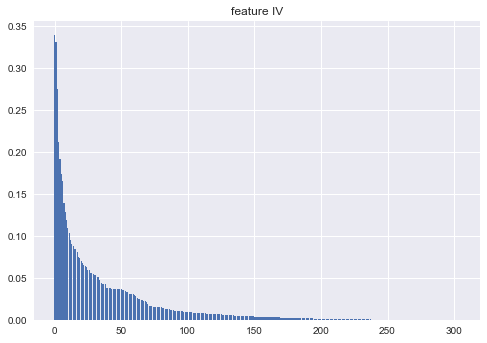

In [240]:
#将变量IV值进行降序排列，方便后续挑选变量
IV_dict_sorted = sorted(IV_dict.items(), key=lambda x: x[1], reverse=True)
IV_values = [i[1] for i in IV_dict_sorted]
IV_name = [i[0] for i in IV_dict_sorted]
plt.title('feature IV')
plt.bar(range(len(IV_values)),IV_values)
plt.show()

In [81]:
'''
2、其他模型筛选变量
1）、随机森林筛选变量 
'''
X_train, X_valid, y_train, y_valid = train_test_split(
    mydata1[num_features], mydata1['target'], train_size=0.9, random_state=233)
clf=RandomForestClassifier(random_state=10,bootstrap=True, criterion='entropy',n_estimators=500)
clf.fit(X_train, y_train)

####变量重要性
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(clf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.reset_index(inplace=True)


'''
2）、Losso 筛选变量
确定最优超参数 alpha
提取系数不为零的变量
'''
lassocv = LassoCV()
lassocv.fit(X_train, y_train)
mask =lassocv.coef_ != 0
new_reg_data = X_train.loc[:,mask]


'''
3）、xgboost 查看变量
'''
nrounds=2000 # need to change to 2000
kfold = 5  # need to change to 5
skf = StratifiedKFold(n_splits=kfold, random_state=29)
params = {'eta': 0.03, 'max_depth': 4, 'subsample': 0.9, 'colsample_bytree': 0.9, 
          'objective': 'binary:logistic', 'eval_metric': ['error','auc'], 'silent': True}
d_train = xgb.DMatrix(X_train, y_train) 
d_valid = xgb.DMatrix(X_valid, y_valid) 
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
xgb_model = xgb.train(params, d_train, nrounds, watchlist,
                      maximize=True, verbose_eval=100,early_stopping_rounds=200)
gc.collect()

###查看变量重要性,取重要性排名前20个变量
score = xgb_model.get_fscore()
score_sorted= sorted(score.items(), key=lambda d: d[1],reverse=True)
    
def To_Bin(list):
    feature=[]
    for var in list:
        newname=var+'_Bin'
        feature.append(newname)
    return(feature)



E:\360Downloads\Python\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[0]	train-error:0.160799	train-auc:0.714638	valid-error:0.184358	valid-auc:0.637494
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 200 rounds.
[100]	train-error:0.154483	train-auc:0.847507	valid-error:0.179702	valid-auc:0.751017
[200]	train-error:0.139573	train-auc:0.90343	valid-error:0.168529	valid-auc:0.777027
[300]	train-error:0.122903	train-auc:0.933155	valid-error:0.164804	valid-auc:0.786667
[400]	train-error:0.107372	train-auc:0.952809	valid-error:0.165736	valid-auc:0.790357
[500]	train-error:0.095258	train-auc:0.966906	valid-error:0.16108	valid-auc:0.791862
[600]	train-error:0.082833	train-auc:0.977165	valid-error:0.162011	valid-auc:0.792426
[700]	train-error:0.07134	train-auc:0.983949	valid-error:0.162011	valid-auc:0.790322
Stopping. Best iteration:
[592]	train-error:0.084179	train-auc:0.97652	valid-error:0.16108	valid-auc:0.79256



NameError: name 'importance' is not defined

In [82]:

print(importances)##查看随机森林变量重要性
print(score_sorted)##查看 xgboost

                                    feature  importance
0                               final_score       0.020
1                                  apply_1m       0.017
2                                  apply_3m       0.016
3           blacklist_indirect_contacts_cnt       0.012
4                         debitcard_balance       0.010
5                                  zm_score       0.010
6                   org_cnt_recent_180_days       0.009
7                                  apply_7d       0.008
8                     blacklist_routers_pct       0.008
9                          extend_phone_age       0.007
10             debitcard_recently_balance_3       0.007
11                    org_180_cnt_14_recent       0.007
12                          peer_loc_cnt_3m       0.006
13                     search_cnt_14_recent       0.006
14                               search_cnt       0.006
15            debitcard_recently_balance_12       0.006
16             debitcard_recently_balance_6     

高IV值筛选出来的变量有： 70
其他模型筛选变量个数： 68
最终变量总个数： 105


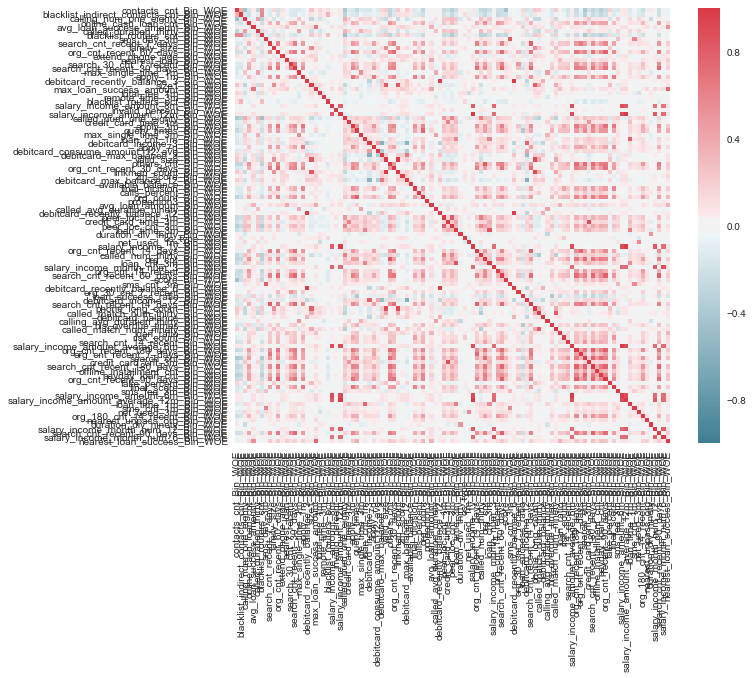

In [271]:

'''
3、变量筛选
1)结合woe、随机森林和xgboost 筛选变量
'''
##IV值筛选出来的变量
high_IV = {k:v for k, v in IV_dict.items() if v >= 0.02}##选取IV值大于0.04的变量（0.2+的变量就有高预测性，0.02以下的变量不具预测性）
high_IV_sorted = sorted(high_IV.items(),key=lambda x:x[1],reverse=True)

looso_features=list(new_reg_data.columns.values)
RF_features=list(importances[:30]['feature']) ##取重要性排名前30的 变量
xgboost_features=[]
for item in score_sorted[:30]:  ##可以选取前20个重要性变量
    xgboost_features.append(item[0])

short_list1 = list(high_IV.keys())
print("高IV值筛选出来的变量有：",len(short_list1))
#high_IV_sorted

RF_feature=To_Bin(RF_features)
xgb_feature=To_Bin(xgboost_features)
#looso_feature=To_Bin(looso_features)
other_future=list(set(RF_feature+xgb_feature))
print('其他模型筛选变量个数：',len(other_future))

short_list = list(set(short_list1 + other_future))
print('最终变量总个数：',len(short_list))
short_list_2 = []
for var in short_list:
    newVar = var + '_WOE'
    trainData[newVar] = trainData[var].map(WOE_dict[var])
    short_list_2.append(newVar)
#对于上一步的结果，计算相关系数矩阵，并画出热力图进行数据可视化
trainDataWOE = trainData[short_list_2]
f, ax = plt.subplots(figsize=(10, 8))
corr = trainDataWOE.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),square=True, ax=ax)
plt.show()
corr.to_csv("F:/onbank_model/相关性矩阵.csv",sep=",", index=False)


In [272]:
'''
2）变量相关性处理
删除相关性大于0.7的变量
'''
short_list_IV = {k:v for k, v in IV_dict.items() if k in short_list}    
IV_short_list=sorted(short_list_IV.items(), key=lambda x: x[1], reverse=True) 


deleted_index = []
cnt_vars = len(short_list_2)
for i in range(cnt_vars):
    if i in deleted_index:
        continue
    x1 = IV_short_list[i][0]+"_WOE"  ##short_list_2[i]代替
    for j in range(cnt_vars):
        if i == j or j in deleted_index:
            continue
        y1 = IV_short_list[j][0]+"_WOE" ##short_list_2[j]代替
        roh = np.corrcoef(trainData[x1],trainData[y1])[0,1]
        if abs(roh)>0.7:
            x1_IV = IV_short_list[i][1]  ##表示变量iv值
            y1_IV = IV_short_list[j][1]
            if x1_IV > y1_IV:
                deleted_index.append(j)
            else:
                deleted_index.append(i)

multi_analysis_vars_1 = [IV_short_list[i][0]+"_WOE"  for i in range(cnt_vars) if i not in deleted_index]
print('删除相关性变量剩余：',len(multi_analysis_vars_1))

'''
这里可以进行相关性变量替换
'''
corr_to_move = [IV_short_list[i][0]+"_WOE"  for i in range(cnt_vars) if i in deleted_index]
corr_to_move  ###要删除的 相关性的变量

# corr_to_move.append('query_times_Bin_WOE')                    
# corr_to_move.remove('org_cnt_Bin_WOE')
multi_analysis_vars_1=[]
for item in short_list:
    new=item+'_WOE'
    if new not in corr_to_move:
        multi_analysis_vars_1.append(new)
        
len(multi_analysis_vars_1)
pd.DataFrame(multi_analysis_vars_1).to_csv("F:/onbank_model/Var.csv", sep=",")

'''
3）多变量分析：VIF
多重共线性判断
'''
X = np.matrix(trainData[multi_analysis_vars_1])
VIF_list = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
max_VIF = max(VIF_list)
print (max_VIF)
# 最大的VIF<5，因此这一步认为多重共线性影响不大
multi_analysis = multi_analysis_vars_1 

y = trainData['y']
X = trainData[multi_analysis]
#X['intercept'] = [1]*X.shape[0]

'''
4) 删除箱中样本数大于一定比率的 变量
'''
dropVar=[]
for name in multi_analysis:
    if X[name].value_counts().iloc[0] / X.shape[0] >=0.8:
        dropVar.append(name)
#dropVar.remove('org_count_Bin_WOE')        
X.drop(dropVar,axis=1,inplace=True)

print('删除一个箱中样本数超过80% 的变量剩余：',len(list(X.columns.values)))

删除相关性变量剩余： 75
3.90559410595


E:\360Downloads\Python\lib\site-packages\ipykernel\__main__.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


删除一个箱中样本数超过80% 的变量剩余： 68


In [273]:
##查看剩余变量的IV值
IV_list=[]
for item in list(X.columns.values):
    new=item[:-4]
    IV_list.append(new)
    
IV = {k:v for k, v in IV_dict.items() if k in IV_list}
IV_sorted = sorted(IV.items(),key=lambda x:x[1],reverse=True)
IV_sorted

[('apply_1m_Bin', 0.33905381693441494),
 ('final_score_Bin', 0.33062031937555508),
 ('apply_3m_Bin', 0.27477389472436969),
 ('final_dicision_Bin', 0.21167744178063358),
 ('apply_7d_Bin', 0.19186228568947863),
 ('org_count_Bin', 0.17345417943925751),
 ('org_cnt_recent_180_days_Bin', 0.16504238270820387),
 ('org_cnt_recent_60_days_Bin', 0.13937867951665117),
 ('org_180_cnt_14_recent_Bin', 0.094997126206968749),
 ('debitcard_balance_Bin', 0.089864115818452411),
 ('loan_ratio_Bin', 0.084562078706266697),
 ('peer_loc_cnt_1m_Bin', 0.074495860919267798),
 ('risk_count_Bin', 0.073836171065598366),
 ('payday_loan_cnt_Bin', 0.069817695854845929),
 ('org_cnt_Bin', 0.06804776068460415),
 ('search_cnt_recent_7_days_Bin', 0.06438262774761308),
 ('zm_score_Bin', 0.058753272728628694),
 ('search_cnt_recent_90_days_Bin', 0.056077069722084899),
 ('max_loan_success_amount_Bin', 0.055390115450341608),
 ('nearest_loan_Bin', 0.054700941349195703),
 ('blacklist_indirect_contacts_cnt_Bin', 0.05105652365066229

In [275]:
'''
这一步 第一次可以跳过，先看自动筛选出来的结果
作为手动调节变量步骤
'''
keep=['blacklist_indirect_contacts_cnt_Bin_WOE',
 'final_score_Bin_WOE',
 'extend_phone_age_Bin_WOE',
 'zm_score_Bin_WOE',
 'apply_1m_Bin_WOE',
 'org_180_cnt_14_recent_Bin_WOE',
 'org_count_Bin_WOE',
 'peer_loc_cnt_1m_Bin_WOE',
 'credit_card_time_3m_Bin_WOE',
 'debitcard_balance_Bin_WOE',
 'loan_ratio_Bin_WOE',
 'blacklist_routers_pct_Bin_WOE',
'debitcard_recently_balance_3_Bin_WOE',
'debitcard_income_3_Bin_WOE'
     ]
X=trainData[keep]

In [276]:
'''
五、逻辑回归模型。
要求：
1，变量显著
2，符号为负
'''
### (1)将多变量分析的后变量带入LR模型中
LR = sm.Logit(y, X).fit()
summary = LR.summary()
pvals = LR.pvalues
pvals = pvals.to_dict()

# ### 有些变量不显著，需要逐步剔除
multi_analysis=list(X.columns.values)
varLargeP = {k: v for k,v in pvals.items() if v >= 0.1}
varLargeP = sorted(varLargeP.items(), key=lambda d:d[1], reverse = True)

while(len(varLargeP) > 0 and len(multi_analysis) > 0):
    # 每次迭代中，剔除最不显著的变量，直到
    # (1) 剩余所有变量均显著
    # (2) 没有特征可选
    varMaxP = varLargeP[0][0]
    print(varMaxP)
    if varMaxP == 'intercept':
        print ('the intercept is not significant!')
        break
    multi_analysis.remove(varMaxP)
    
    y = trainData['y']
    X = trainData[multi_analysis]
    #X['intercept'] = [1] * X.shape[0]

    LR = sm.Logit(y, X).fit()
    #summary = LR.summary()
    pvals = LR.pvalues
    pvals = pvals.to_dict()
    varLargeP = {k: v for k, v in pvals.items() if v >= 0.01}
    varLargeP = sorted(varLargeP.items(), key=lambda d: d[1], reverse=True)

Optimization terminated successfully.
         Current function value: 0.591844
         Iterations 5


In [277]:
from sklearn.metrics import roc_auc_score
trainData['prob'] = LR.predict(X)
auc = roc_auc_score(trainData['y'],trainData['prob']) 
print('逻辑回归AUC面积为：',auc)

逻辑回归AUC面积为： 0.74960210102


In [279]:
'''
六、确定最终变量及其分箱得分
'''
used_feature = []

last_features=list(LR.params.index.values)
#last_features.remove('os_type_WOE')


for item in last_features:
    if(LR.params[item] < 0 and item != 'intercept'):
        used_feature.append(item[:-8])
        
#used_feature.append('os_type')

def to_df(interval, values,name):
    if -float("inf") in interval:
        interval.remove(-float("inf"))
    if float("inf") in interval:
        interval.remove(float("inf"))
    print(interval)
    interval = interval.copy()
    interval.insert(0, -float("inf"))
    interval.append(float("inf"))
    ninterval = []
    for i in range(0,len(interval) - 1):
        tempstr = str(interval[i]) + ',' + str(interval[i + 1])
        ninterval.append(tempstr)
    ninterval.insert(0, name)
    values.insert(0, '   ')
    result = pd.DataFrame(ninterval,columns = ['interval'])
    result['value'] = values
    return result
        
result = pd.DataFrame()
for name in used_feature:
    values = []
    if name in continous_merged_dict.keys():
        print(name)
        print(continous_merged_dict[name])
        interval = continous_merged_dict[name]
        new = name + "_Bin" 
        coef = LR.params[new + "_WOE"]
        for key, value in WOE_dict[new].items():
            print(key,value *43.28085 * -1 * coef)
            values.append(value *43.28085 * -1 * coef)
        result = result.append(to_df(interval,values,name))
    else:
        print(name)
        for key, value in WOE_dict[name].items():
            print(key,value *43.28085 * -1 * coef)
            values.append(value *43.28085 * -1 * coef)            
        result = result.append(to_df(interval,values,name))
        
result.to_csv('F:/onbank_model/myPython/interval_814_rank.csv',index = False)


blacklist_indirect_contacts_cnt
[85.0, 930.0, 1716.0]
Bin 0 -7.285377599
Bin 1 -6.45958034465
Bin 2 24.8385480812
Bin 3 32.7301953113
[85.0, 930.0, 1716.0]
final_score
[44.0, 109.0, 143.0, 177.0]
Bin 0 27.2303275038
Bin 1 6.51806431978
Bin 2 -13.508207003
Bin 3 -20.6629768361
Bin 4 -31.6278950041
[44.0, 109.0, 143.0, 177.0]
extend_phone_age
[987.0, 1420.0, 2301.0, 3717.0]
Bin 0 -9.39855932985
Bin 1 -7.57011064055
Bin 2 -0.95903580834
Bin 3 5.9984930282
Bin 4 21.0841172733
[987.0, 1420.0, 2301.0, 3717.0]
zm_score
[577.0, 605.0, 655.0, 692.0]
Bin 0 -25.0366736175
Bin 1 -19.5272693077
Bin 2 -4.45625573547
Bin 3 5.87251309183
Bin 4 16.8195753952
[577.0, 605.0, 655.0, 692.0]
apply_1m
[13.0, 34.0, 41.0, 56.0]
Bin 0 16.0095692051
Bin 1 -7.5542608581
Bin 2 -29.3312531519
Bin 3 -39.6240309021
Bin 4 -69.1715833979
[13.0, 34.0, 41.0, 56.0]
org_180_cnt_14_recent
[5, 21, 37]
Bin 0 4.56167629526
Bin 1 -3.06009434088
Bin 2 -13.5252915085
Bin 3 -55.970397384
[5, 21, 37]
org_count
[1.0, 3.0, 15.0, 19.0

In [280]:
used_feature

['blacklist_indirect_contacts_cnt',
 'final_score',
 'extend_phone_age',
 'zm_score',
 'apply_1m',
 'org_180_cnt_14_recent',
 'org_count',
 'peer_loc_cnt_1m',
 'credit_card_time_3m',
 'debitcard_balance',
 'loan_ratio',
 'blacklist_routers_pct',
 'debitcard_recently_balance_3',
 'debitcard_income_3']

In [281]:
'''
七、计算得分
'''
##计算训练集上得分
train_score=train[used_feature]
for name in train_score.columns.values:
    if name in continous_merged_dict.keys():
        new_name = name + "_Bin"
        temp_cutoff = continous_merged_dict[name]
        train_score[new_name] = train_score[name].map(lambda x: AssignBin(x, temp_cutoff))##对测试集原始数据 根据区间段进行 分箱
        train_score.drop([name],axis = 1, inplace = True)
        
for name in train_score.columns.values:
    new_name = name + "_WOE"
    woe = WOE_dict[name] 
    train_score[new_name] = train_score[name].map(lambda x: woe[x])
    train_score.drop([name],axis = 1, inplace = True)
    
    
for name in train_score.columns.values:
    coef = LR.params[name]
    train_score[name] = coef * train_score[name]  * 43.28085 * -1

train_score['score']=train_score.sum(axis = 1)
pd.concat([train_score['score'], mydata1['target']], axis=1).to_csv('F:/811train_rank.csv',index = False)

'''
计算测试集上的评分
'''
test1=test[used_feature]
for name in test1.columns.values:
    if name in continous_merged_dict.keys():
        new_name = name + "_Bin"
        temp_cutoff = continous_merged_dict[name]
        test1[new_name] = test1[name].map(lambda x: AssignBin(x, temp_cutoff))##对测试集原始数据 根据区间段进行 分箱
        test1.drop([name],axis = 1, inplace = True)
        
for name in test1.columns.values:
    new_name = name + "_WOE"
    woe = WOE_dict[name] 
    test1[new_name] = test1[name].map(lambda x: woe[x])
    test1.drop([name],axis = 1, inplace = True)
    
for name in test1.columns.values:
    coef = LR.params[name]
    test1[name] = coef * test1[name]  * 43.28085 * -1

test1['score']=test1.sum(axis = 1)
#result=pd.concat([test1['score'], test['target']], axis=1)
pd.concat([test1['score'], test['target']], axis=1).to_csv('F:/808test_rank.csv',index = False)

E:\360Downloads\Python\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
E:\360Downloads\Python\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
E:\360Downloads\Python\lib\site-packages\ipykernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
E:\360Downloads\Python\lib\site-packages\ipy